In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd

zip_path = "/content/drive/My Drive/ColabData/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in zip:", z.namelist())
    with z.open('creditcard.csv') as f:
        data = pd.read_csv(f)
data.head()

Files in zip: ['creditcard.csv']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Basic Information of the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807

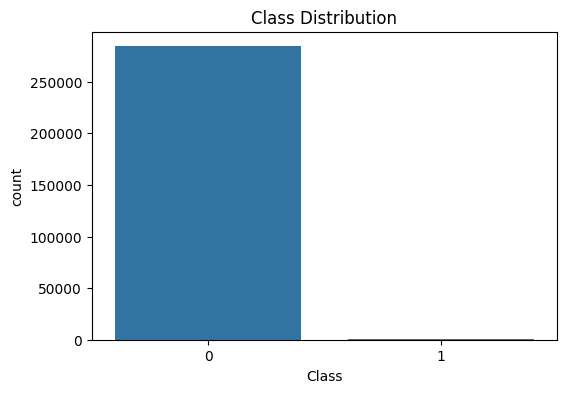

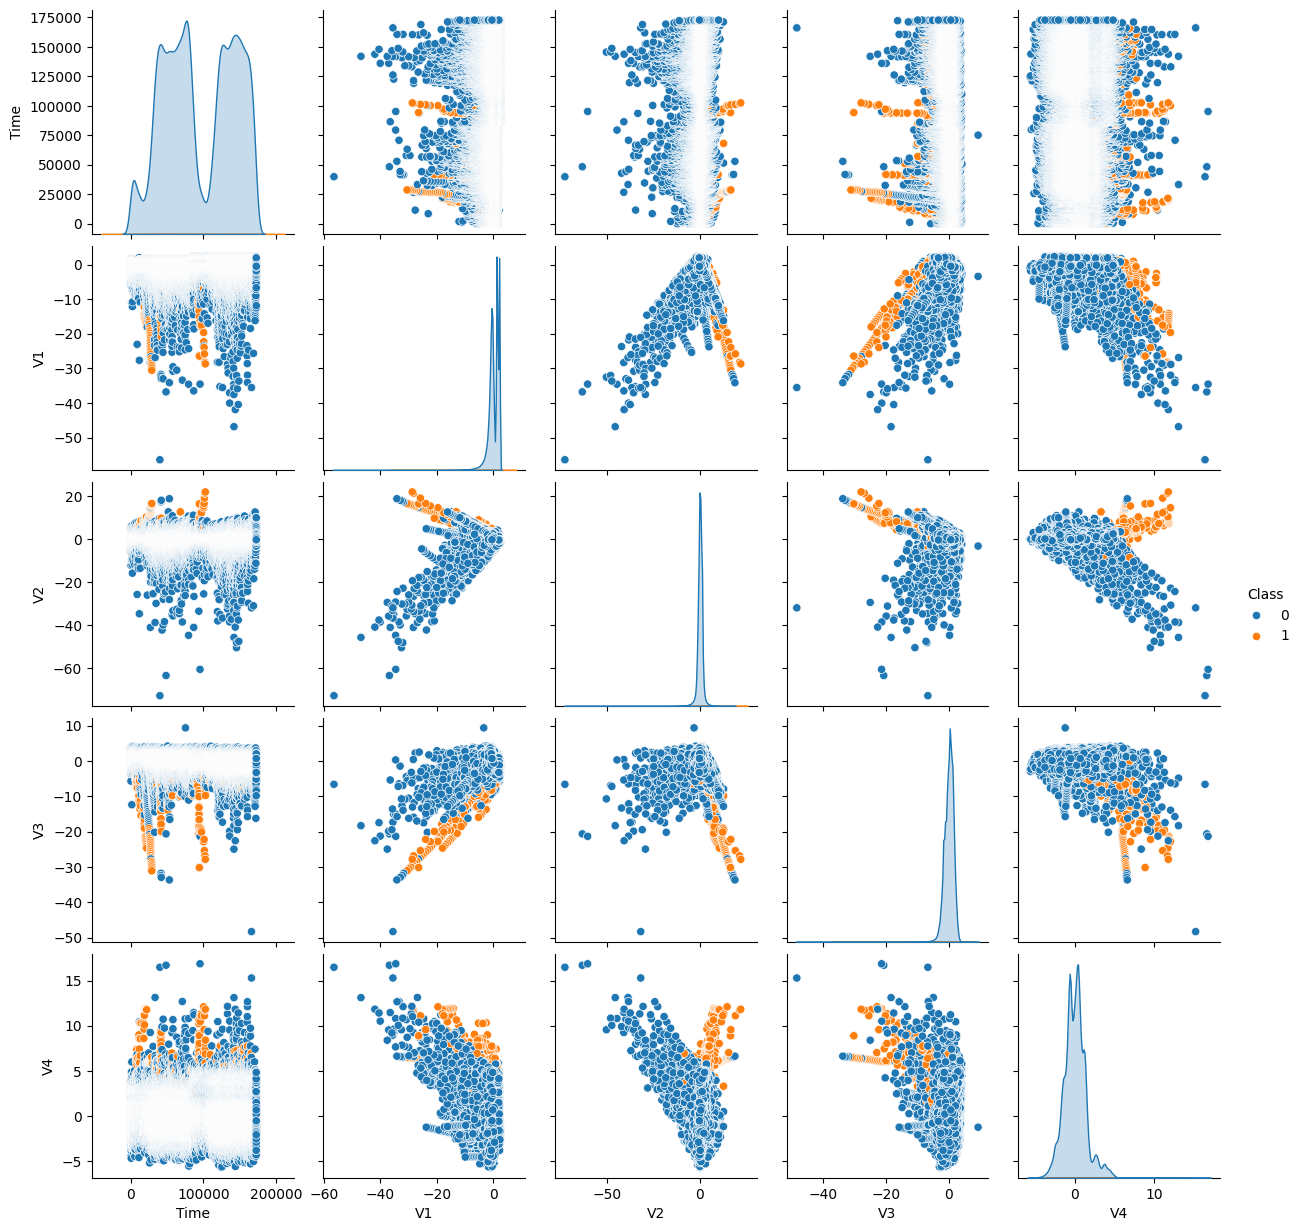


Correlation Matrix:
            Time            V1            V2            V3            V4  \
Time    1.000000  1.173963e-01 -1.059333e-02 -4.196182e-01 -1.052602e-01   
V1      0.117396  1.000000e+00  4.135835e-16 -1.227819e-15 -9.215150e-16   
V2     -0.010593  4.135835e-16  1.000000e+00  3.243764e-16 -1.121065e-15   
V3     -0.419618 -1.227819e-15  3.243764e-16  1.000000e+00  4.711293e-16   
V4     -0.105260 -9.215150e-16 -1.121065e-15  4.711293e-16  1.000000e+00   
V5      0.173072  1.812612e-17  5.157519e-16 -6.539009e-17 -1.719944e-15   
V6     -0.063016 -6.506567e-16  2.787346e-16  1.627627e-15 -7.491959e-16   
V7      0.084714 -1.005191e-15  2.055934e-16  4.895305e-16 -4.104503e-16   
V8     -0.036949 -2.433822e-16 -5.377041e-17 -1.268779e-15  5.697192e-16   
V9     -0.008660 -1.513678e-16  1.978488e-17  5.568367e-16  6.923247e-16   
V10     0.030617  7.388135e-17 -3.991394e-16  1.156587e-15  2.232685e-16   
V11    -0.247689  2.125498e-16  1.975426e-16  1.576830e-15  3.45938

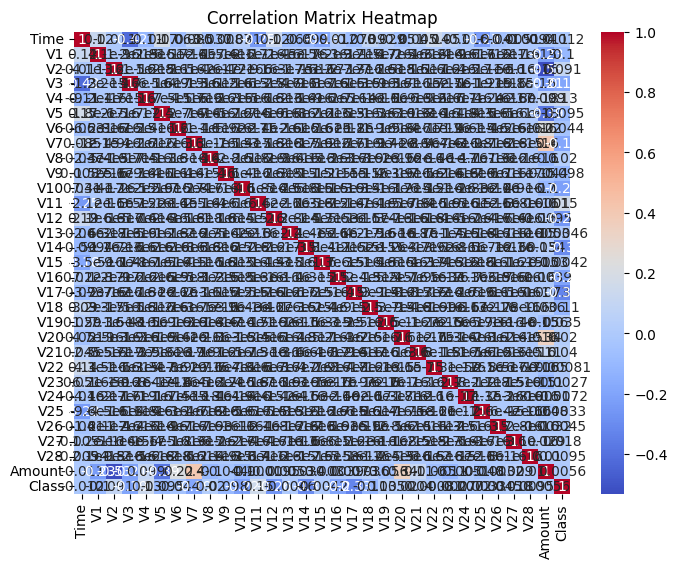

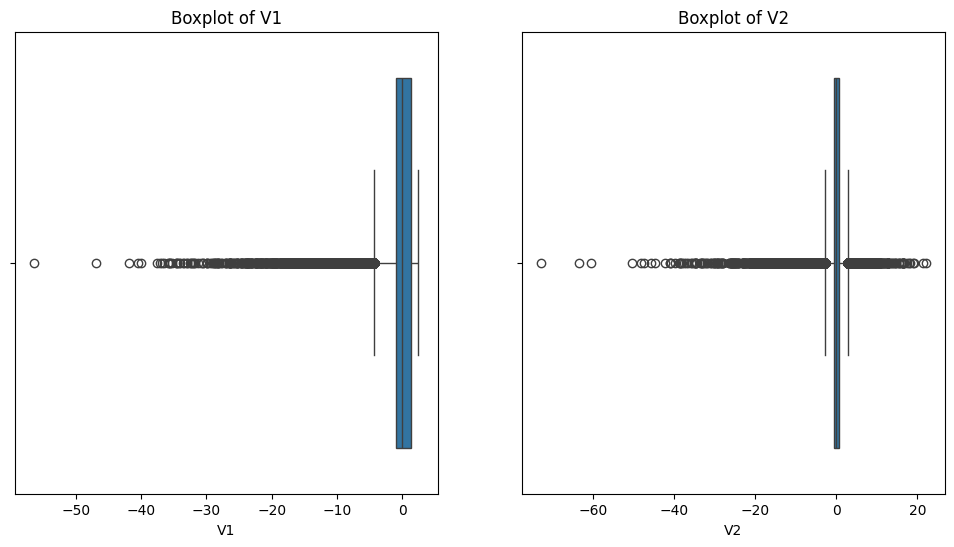

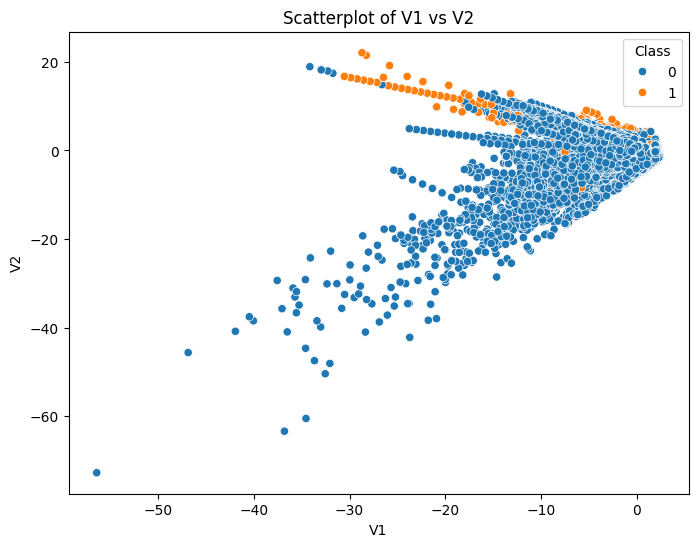

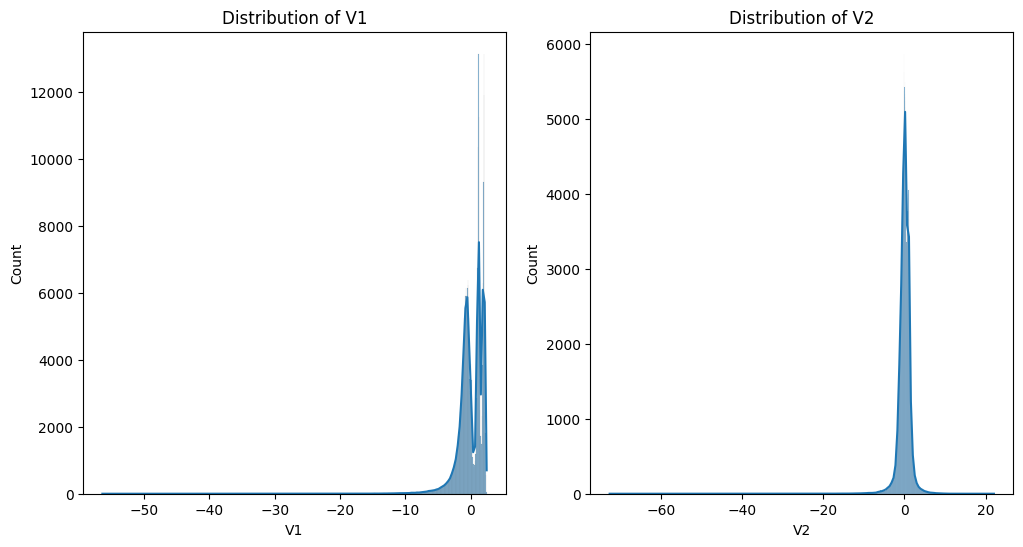

In [ ]:
print("Basic Information of the Dataset:")
print(data.info())

print("\nDescriptive Statistics:")
print(data.describe())

print("\nMissing Values in the Dataset:")
print(data.isnull().sum())

print("\nClass Distribution:")
print(data['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

# Pairplot to visualize rel btwn features
sns.pairplot(data.iloc[:, :5].join(data['Class']), hue='Class')  # Adjust column slice as needed
plt.show()

correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.boxplot(x=data['V1'])
plt.title('Boxplot of V1')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['V2'])
plt.title('Boxplot of V2')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='V1', y='V2', hue='Class', data=data)
plt.title('Scatterplot of V1 vs V2')
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(data['V1'], kde=True)
plt.title('Distribution of V1')

plt.subplot(1, 2, 2)
sns.histplot(data['V2'], kde=True)
plt.title('Distribution of V2')
plt.show()


In [ ]:
# Data Preprocessing
scaler = StandardScaler()
data['normalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)

# Handle Imbalance
X = data.drop('Class', axis=1)
y = data['Class']
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

resampled_df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='Class')], axis=1)

# Display a few rows from both Class 0 and Class 1
print("\nSample Non-Fraud Transactions (Class 0):")
print(resampled_df[resampled_df['Class'] == 0].head())

print("\nSample Fraud Transactions (Class 1):")
print(resampled_df[resampled_df['Class'] == 1].head())


Sample Non-Fraud Transactions (Class 0):
              V1        V2        V3        V4        V5        V6        V7  \
138028  1.314539  0.590643 -0.666593  0.716564  0.301978 -1.125467  0.388881   
63099  -0.798672  1.185093  0.904547  0.694584  0.219041 -0.319295  0.495236   
73411  -0.391128 -0.245540  1.122074 -1.308725 -0.639891  0.008678 -0.701304   
164247 -0.060302  1.065093 -0.987421 -0.029567  0.176376 -1.348539  0.775644   
148999  1.848433  0.373364  0.269272  3.866438  0.088062  0.970447 -0.721945   

              V8        V9       V10  ...       V21       V22       V23  \
138028 -0.288390 -0.132137 -0.597739  ... -0.170307 -0.429655 -0.141341   
63099   0.139269 -0.760214  0.170547  ...  0.202287  0.578699 -0.092245   
73411  -0.027315 -2.628854  2.051312  ... -0.133485  0.117403 -0.191748   
164247  0.134843 -0.149734 -1.238598  ...  0.355576  0.907570 -0.018454   
148999  0.235983  0.683491  1.166335  ...  0.103563  0.620954  0.197077   

             V24       V25

<ipython-input-6-26f49f7d9ddd>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=balanced_df, palette='Set2')


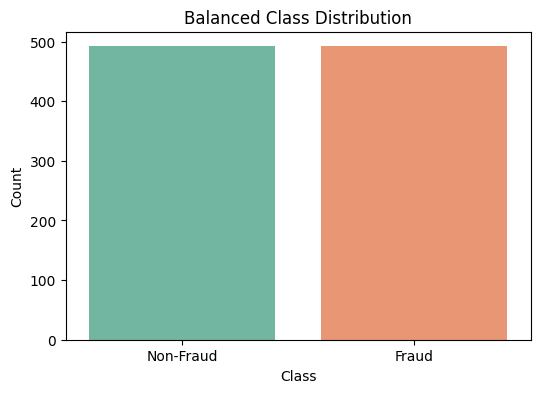

Sample rows from the balanced dataset:
         V1        V2        V3        V4        V5        V6        V7  \
0  1.984787 -1.937036  0.486613 -1.245536 -2.518536 -0.544524 -1.819244   
1 -0.613696  3.698772 -5.534941  5.620486  1.649263 -2.335145 -0.907188   
2  0.319007 -1.072867 -0.216146  1.494709 -0.627063 -0.761867  0.941687   
3 -6.682832 -2.714268 -5.774530  1.449792 -0.661836 -1.148650  0.849686   
4 -6.713407  3.921104 -9.746678  5.148263 -5.151563 -2.099389 -5.937767   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.074875 -0.659777  1.407038  ...  0.174011  0.889289  0.218248  0.492384   
1  0.706362 -3.747646 -4.230984  ...  0.319261 -0.471379 -0.075890 -0.667909   
2 -0.430272 -0.267431 -0.245992  ...  0.332521 -0.022461 -0.537691  0.452072   
3  0.433427 -1.315646 -2.796332  ...  0.220526  1.187013  0.335821  0.215683   
4  3.578780 -4.684952 -8.537758  ...  0.954272 -0.451086  0.127214 -0.339450   

        V25       V26       V

In [ ]:
#Separate fraud and non-fraud trans
fraud_df = data[data['Class'] == 1]
non_fraud_df = data[data['Class'] == 0]

non_fraud_sampled = non_fraud_df.sample(n=len(fraud_df), random_state=42)

balanced_df = pd.concat([fraud_df, non_fraud_sampled], axis=0)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Disply class distr
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=balanced_df, palette='Set2')
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.show()

print("Sample rows from the balanced dataset:")
print(balanced_df.head())

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.3 MB/s eta 0:00:00



Logistic Regression
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



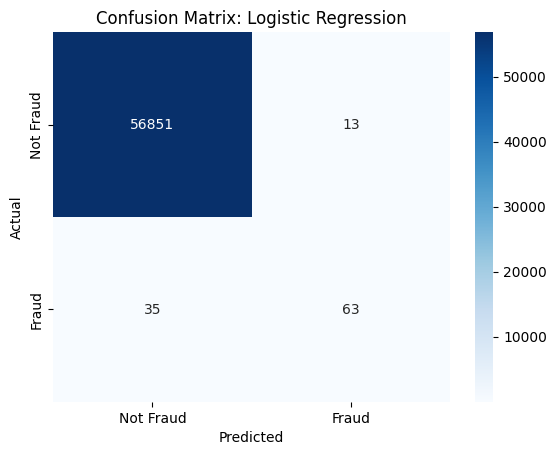


Random Forest
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



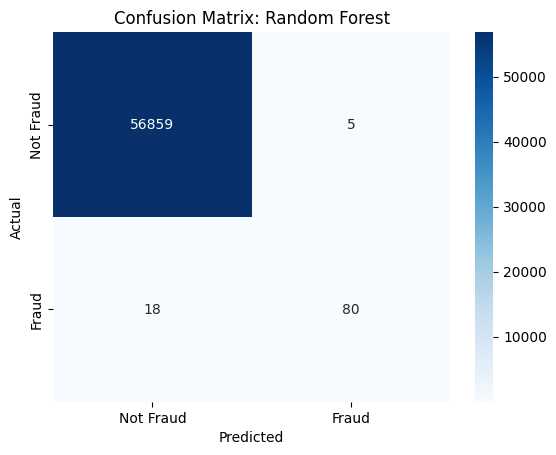


Support Vector Machine
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.69      0.80        98

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962



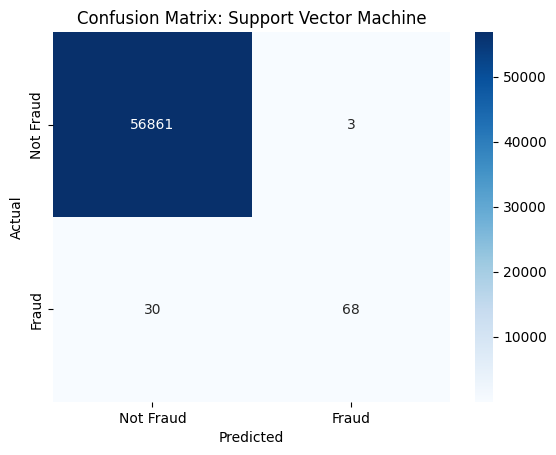

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



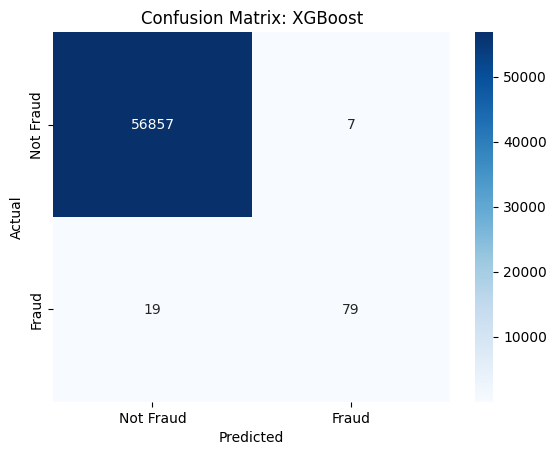


Isolation Forest
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



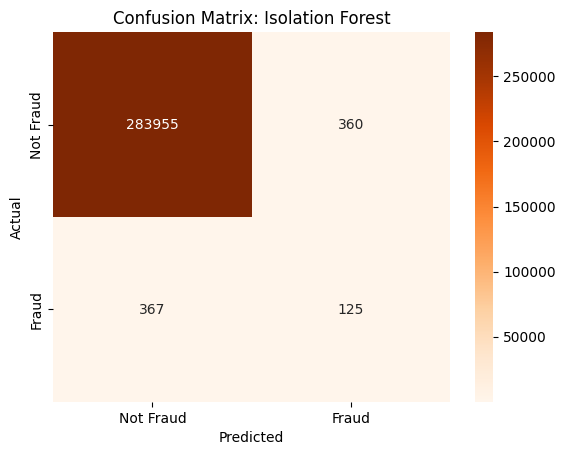


CatBoost Classifier
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



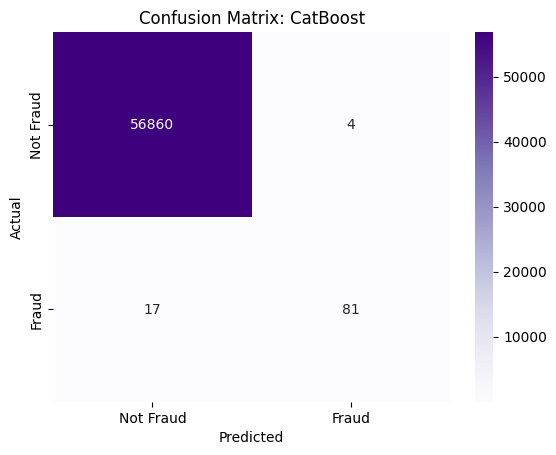

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.03054 |  0:00:12s
epoch 1  | loss: 0.00608 |  0:00:25s
epoch 2  | loss: 0.00504 |  0:00:38s
epoch 3  | loss: 0.00531 |  0:00:50s
epoch 4  | loss: 0.00539 |  0:01:03s
epoch 5  | loss: 0.00479 |  0:01:15s
epoch 6  | loss: 0.00441 |  0:01:27s
epoch 7  | loss: 0.00439 |  0:01:40s
epoch 8  | loss: 0.00532 |  0:01:52s
epoch 9  | loss: 0.00442 |  0:02:05s

TabNet
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.77      0.79        98

    accuracy                           1.00     56962
   macro avg       0.90      0.88      0.89     56962
weighted avg       1.00      1.00      1.00     56962



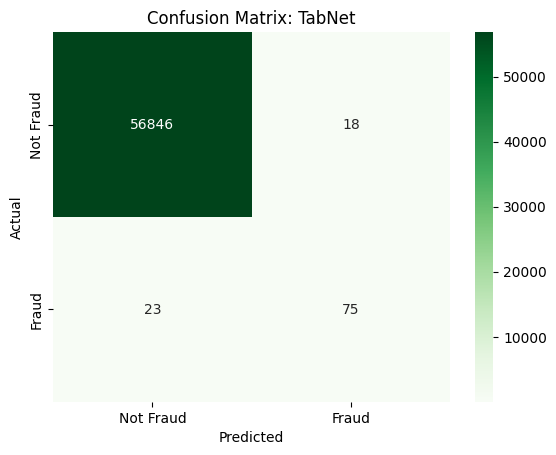


--- Summary of ROC-AUC Scores ---
                    Model   ROC-AUC
5                CatBoost  0.913230
1           Random Forest  0.908119
3                 XGBoost  0.903000
6                  TabNet  0.882495
2  Support Vector Machine  0.846912
0     Logistic Regression  0.821314
4        Isolation Forest  0.626399


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocess data
X = data.drop(columns=['Class'])
y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert for PyTorch
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.long)

results = []

# --- 1. Sklearn models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train_np, y_train_np)
    y_pred = model.predict(X_test_np)
    roc = roc_auc_score(y_test_np, y_pred)
    results.append({"Model": name, "ROC-AUC": roc})
    print(f"\n{name}\n", classification_report(y_test_np, y_pred))
    sns.heatmap(confusion_matrix(y_test_np, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- 2. Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso.fit(X_scaled)
y_pred_iso = [1 if x == -1 else 0 for x in iso.predict(X_scaled)]
roc_iso = roc_auc_score(y, y_pred_iso)
results.append({"Model": "Isolation Forest", "ROC-AUC": roc_iso})
print("\nIsolation Forest\n", classification_report(y, y_pred_iso))
sns.heatmap(confusion_matrix(y, y_pred_iso), annot=True, fmt="d", cmap="Oranges", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix: Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 3. CatBoost Classifier
catboost = CatBoostClassifier(verbose=0, random_seed=42)
catboost.fit(X_train_np, y_train_np)
y_pred_cat = catboost.predict(X_test_np)
roc_cat = roc_auc_score(y_test_np, y_pred_cat)
results.append({"Model": "CatBoost", "ROC-AUC": roc_cat})
print("\nCatBoost Classifier\n", classification_report(y_test_np, y_pred_cat))
sns.heatmap(confusion_matrix(y_test_np, y_pred_cat), annot=True, fmt="d", cmap="Purples", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix: CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 4. TabNet Classifier
tabnet = TabNetClassifier()
tabnet.fit(X_train_np, y_train_np, max_epochs=10, patience=5, batch_size=1024, virtual_batch_size=128)
y_pred_tabnet = tabnet.predict(X_test_np)
roc_tabnet = roc_auc_score(y_test_np, y_pred_tabnet)
results.append({"Model": "TabNet", "ROC-AUC": roc_tabnet})
print("\nTabNet\n", classification_report(y_test_np, y_pred_tabnet))
sns.heatmap(confusion_matrix(y_test_np, y_pred_tabnet), annot=True, fmt="d", cmap="Greens", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix: TabNet")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Summary
print("\n--- Summary of ROC-AUC Scores ---")
summary_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print(summary_df)

<ipython-input-9-7827c0dfe3f3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="viridis")


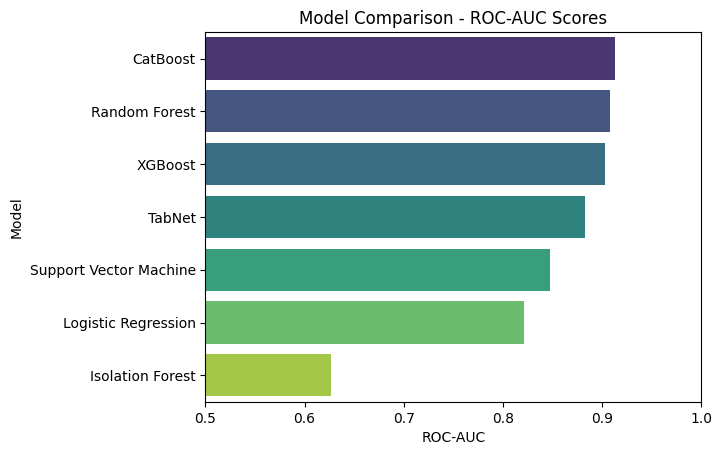

In [ ]:
# Visual Comparison of Models
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="ROC-AUC", ascending=False)
sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison - ROC-AUC Scores")
plt.xlim(0.5, 1.0)
plt.show()

<ipython-input-10-75451dfae6fb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, y='ROC-AUC', x='Model', palette='Set2')


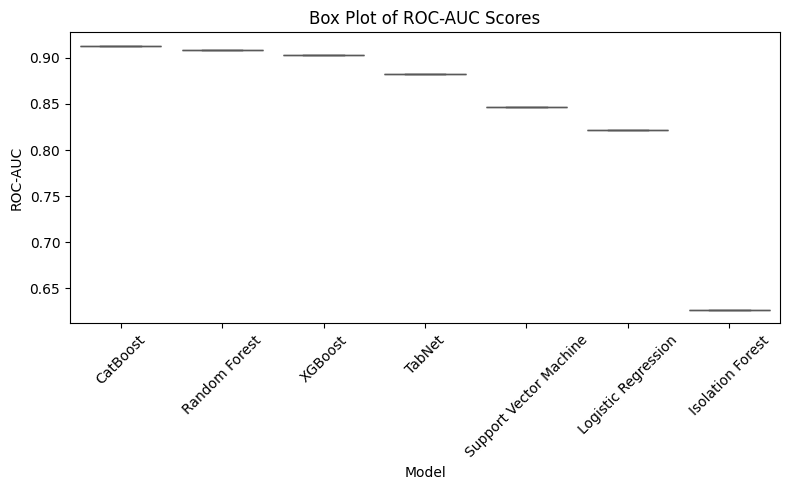

In [ ]:
# Box Plot of ROC-AUC Scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, y='ROC-AUC', x='Model', palette='Set2')
plt.title('Box Plot of ROC-AUC Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

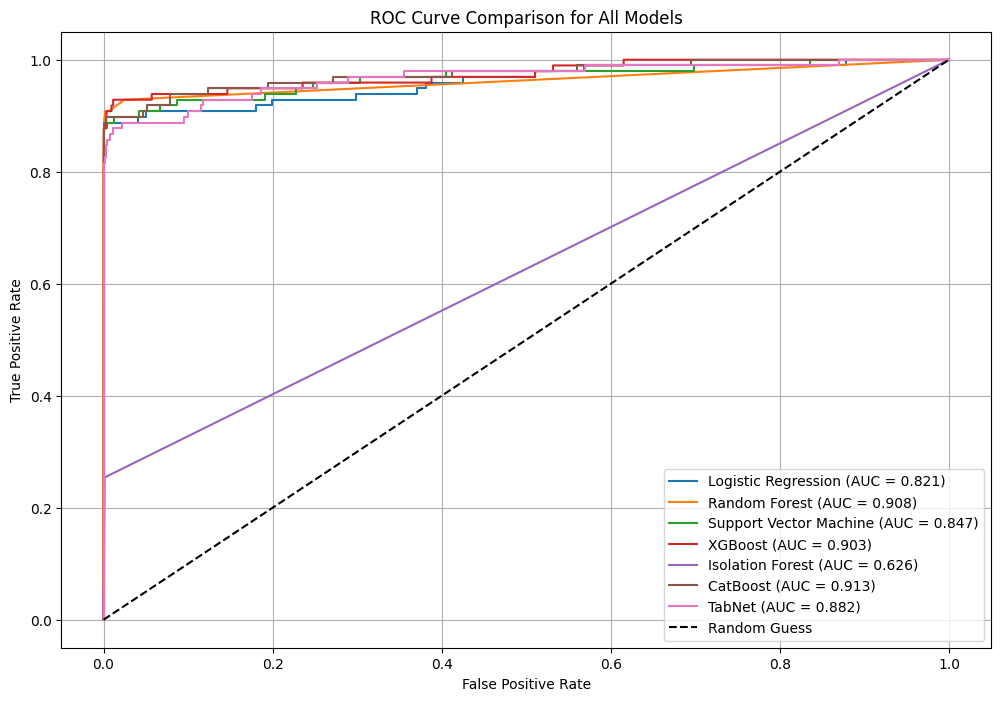

In [ ]:
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier

plt.figure(figsize=(12, 8))

# 1. Sklearn Models
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_np)[:, 1]
    else:
        y_scores = model.decision_function(X_test_np)
    fpr, tpr, _ = roc_curve(y_test_np, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test_np, model.predict(X_test_np)):.3f})")

# 2. Isolation Forest
fpr_iso, tpr_iso, _ = roc_curve(y, y_pred_iso)
plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC = {roc_iso:.3f})")

# 3. CatBoost Model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train_np, y_train_np)
catboost_probs = catboost_model.predict_proba(X_test_np)[:, 1]
catboost_pred = catboost_model.predict(X_test_np)
roc_catboost = roc_auc_score(y_test_np, catboost_pred)

fpr_catboost, tpr_catboost, _ = roc_curve(y_test_np, catboost_probs)
plt.plot(fpr_catboost, tpr_catboost, label=f"CatBoost (AUC = {roc_catboost:.3f})")

# 4. TabNet
tabnet_probs = tabnet.predict_proba(X_test_np)[:, 1]
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test_np, tabnet_probs)
plt.plot(fpr_tabnet, tpr_tabnet, label=f"TabNet (AUC = {roc_tabnet:.3f})")

# Final plot adjustments
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:19:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.03054 |  0:00:12s
epoch 1  | loss: 0.00608 |  0:00:25s
epoch 2  | loss: 0.00504 |  0:00:38s
epoch 3  | loss: 0.00531 |  0:00:51s
epoch 4  | loss: 0.00539 |  0:01:03s
epoch 5  | loss: 0.00479 |  0:01:17s
epoch 6  | loss: 0.00441 |  0:01:29s
epoch 7  | loss: 0.00439 |  0:01:42s
epoch 8  | loss: 0.00532 |  0:01:54s
epoch 9  | loss: 0.00442 |  0:02:07s

--- Precision and Accuracy Summary ---
                    Model  Precision  Accuracy
5                CatBoost   0.952941  0.999631
1           Random Forest   0.941176  0.999596
3                 XGBoost   0.918605  0.999544
2  Support Vector Machine   0.957746  0.999421
6                  TabNet   0.806452  0.999280
0     Logistic Regression   0.828947  0.999157
4        Isolation Forest   0.257732  0.997447


<Figure size 1200x600 with 0 Axes>

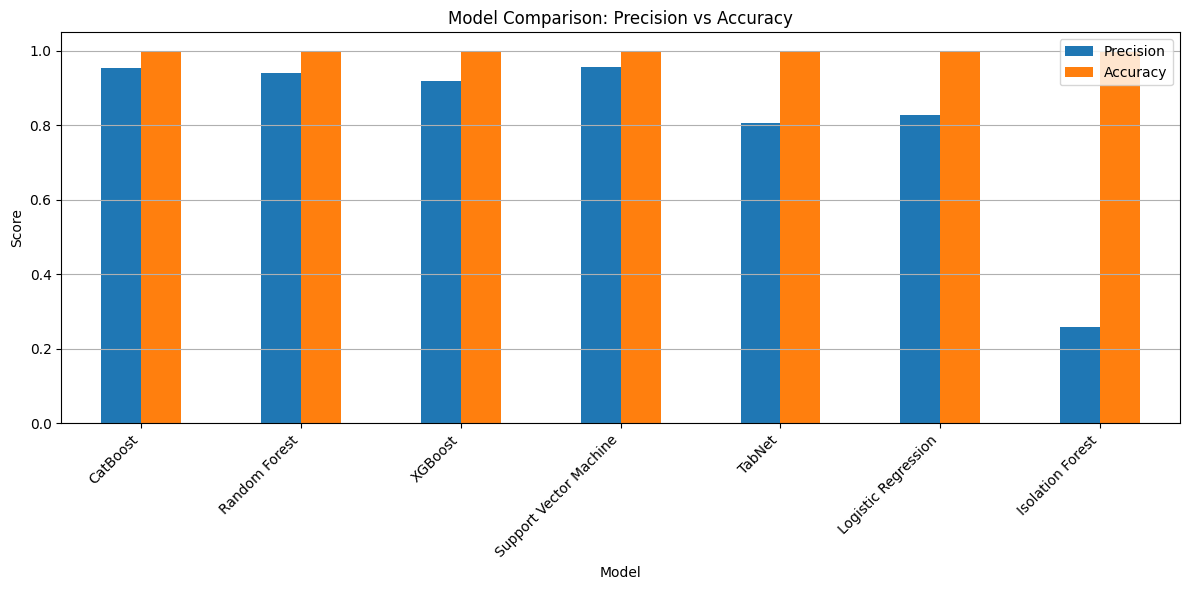

In [ ]:
from sklearn.metrics import precision_score, accuracy_score
from catboost import CatBoostClassifier

results = []

# --- 1. Sklearn models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Store evaluation results in a structured format
for name, model in models.items():
    model.fit(X_train_np, y_train_np)
    y_pred = model.predict(X_test_np)
    precision = precision_score(y_test_np, y_pred)
    accuracy = accuracy_score(y_test_np, y_pred)

    results.append({
        "Model": name,
        "Precision": precision,
        "Accuracy": accuracy
    })

# --- 2. Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso.fit(X_scaled)
y_pred_iso = [1 if x == -1 else 0 for x in iso.predict(X_scaled)]
precision_iso = precision_score(y, y_pred_iso)
accuracy_iso = accuracy_score(y, y_pred_iso)

results.append({
    "Model": "Isolation Forest",
    "Precision": precision_iso,
    "Accuracy": accuracy_iso
})

# --- 3. CatBoost Classifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train_np, y_train_np)
y_pred_catboost = catboost_model.predict(X_test_np)
precision_catboost = precision_score(y_test_np, y_pred_catboost)
accuracy_catboost = accuracy_score(y_test_np, y_pred_catboost)

results.append({
    "Model": "CatBoost",
    "Precision": precision_catboost,
    "Accuracy": accuracy_catboost
})

# --- 4. TabNet Classifier
tabnet = TabNetClassifier()
tabnet.fit(X_train_np, y_train_np, max_epochs=10, patience=5, batch_size=1024, virtual_batch_size=128)
y_pred_tabnet = tabnet.predict(X_test_np)
precision_tabnet = precision_score(y_test_np, y_pred_tabnet)
accuracy_tabnet = accuracy_score(y_test_np, y_pred_tabnet)

results.append({
    "Model": "TabNet",
    "Precision": precision_tabnet,
    "Accuracy": accuracy_tabnet
})

# --- Final Summary Table
summary_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\n--- Precision and Accuracy Summary ---")
print(summary_df)

# --- Visualization
plt.figure(figsize=(12, 6))
summary_df_plot = summary_df.set_index("Model")

# Plot Precision and Accuracy
summary_df_plot[["Precision", "Accuracy"]].plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison: Precision vs Accuracy")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Install SHAP
!pip install shap

import shap
shap.initjs()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import zipfile
import pandas as pd

zip_path = "/content/drive/My Drive/ColabData/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in zip:", z.namelist())
    with z.open('creditcard.csv') as f:
        data = pd.read_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in zip: ['creditcard.csv']


In [ ]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
# Load and prepare data
X = data.drop(columns=['Class'])
y = data['Class']

# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split dataset
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')  # No need for `use_label_encoder`
xgb_model.fit(X_train_np, y_train_np)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

100%|===================| 56750/56962 [03:27<00:00]       

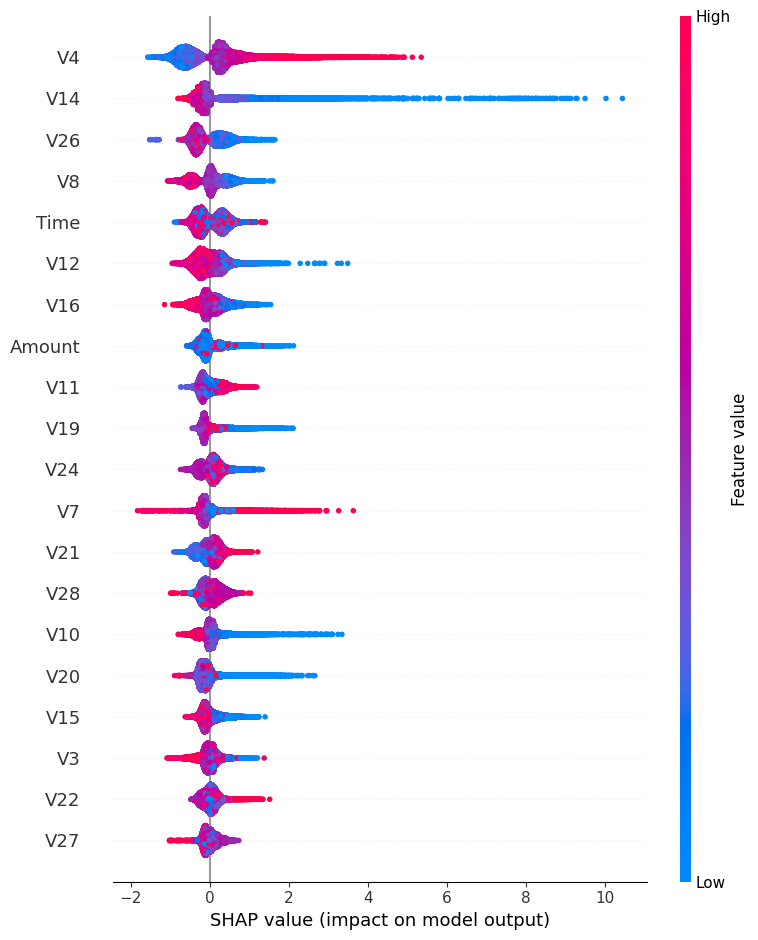

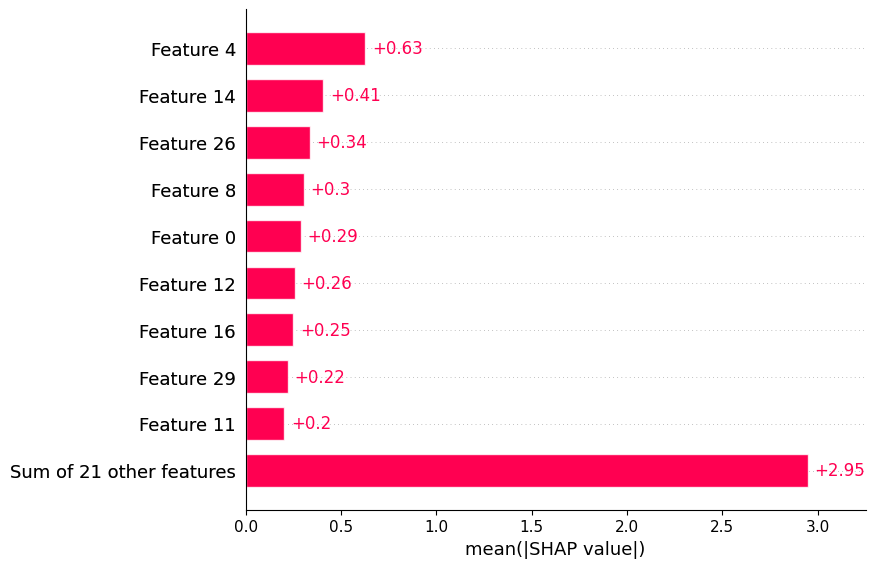

In [ ]:
# Initialize SHAP
shap.initjs()

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_np)

# Get SHAP values
shap_values = explainer(X_test_np)

# Plot summary
shap.summary_plot(shap_values, X_test_np, feature_names=X.columns)

shap.plots.bar(shap_values, max_display=10)  # Top 10 features

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=e266b1e4cf34621cb7d467f39796368ccc4e6e97d757936601e8c823ba0eda56
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
from ydata_profiling import ProfileReport
import pandas as pd
data = pd.DataFrame(data, columns=['y', 'y_prime', 'Class'])
data["Class"] = data["Class"].replace([1], 0)
data["Class"] = data["Class"].replace([2], 1)

profile = ProfileReport(data, title="EDA Report for CreditCard Dataset", explorative=True)
profile.to_file("EDA_Report.html")

# Create profile report
profile = ProfileReport(data, title="EDA Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download("EDA_Report.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>